In [1]:
# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

import seaborn as sns

import os



In [2]:
data = pd.read_csv("ocular_disease_full_df.csv")
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
#Create a function which will find all instances of glaucoma in the dataset. 
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0
data["left_glaucoma"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
data["right_glaucoma"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

#Compile a list of all the images from the left and right eye images that have 
left_glaucoma = data.loc[(data.G ==1) & (data.left_glaucoma == 1)]["Left-Fundus"].values
print(left_glaucoma[:10])
right_glaucoma = data.loc[(data.G ==1) & (data.right_glaucoma == 1)]["Right-Fundus"].values
print(right_glaucoma[:15])

['95_left.jpg' '153_left.jpg' '167_left.jpg' '178_left.jpg' '247_left.jpg'
 '365_left.jpg' '583_left.jpg' '625_left.jpg' '746_left.jpg'
 '931_left.jpg']
['43_right.jpg' '167_right.jpg' '238_right.jpg' '247_right.jpg'
 '365_right.jpg' '583_right.jpg' '746_right.jpg' '931_right.jpg'
 '1209_right.jpg' '1210_right.jpg' '1211_right.jpg' '1212_right.jpg'
 '1213_right.jpg' '1214_right.jpg' '1215_right.jpg']


In [4]:
print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))

Number of images in left glaucoma: 332
Number of images in right glaucoma: 284


In [5]:
left_normal = data.loc[(data.G ==0) & (data.N ==1) & (data["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(310,random_state=55).values
right_normal = data.loc[(data.G ==0) & (data.N ==1) & (data["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(310,random_state=55).values
right_normal[:15]

glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [6]:
print(len(glaucoma),len(normal))

616 620


In [7]:
#Creating a function to load the preprocessed images in a dataset and shuffle  
dataset_dir = "C:/Users/chris/OneDrive/desktop/Ocular_Images/preprocessed_images"
image_size=224
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = imread(image_path)
            image = resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [8]:
#Creating a dataset with 'Glaucoma' and 'Normal' images
dataset = create_dataset(glaucoma,1)

len(dataset)

dataset = create_dataset(normal,0)

len(dataset)

100%|██████████| 620/620 [00:50<00:00, 12.26it/s]


1233

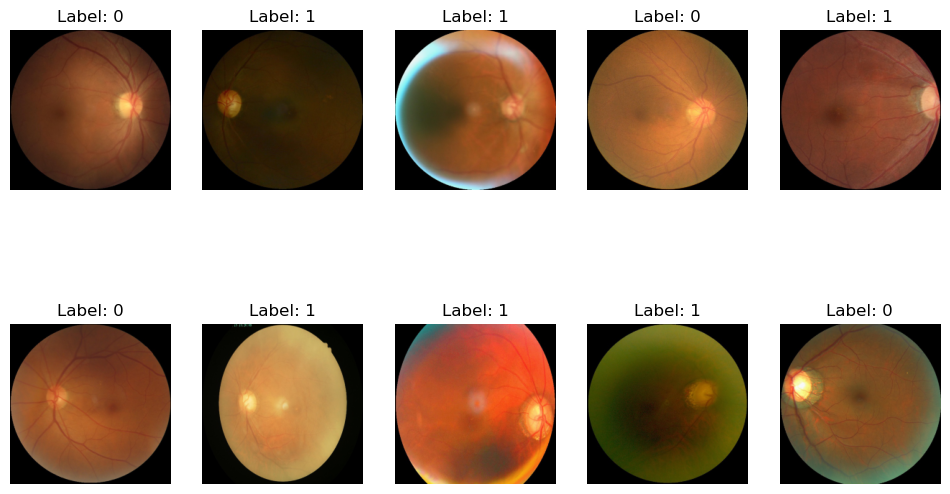

In [9]:
#Showing an sample of the dataset with labelled images. A value of '0' denotes 'Normal', while '1' means 'Glaucoma'
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    plt.subplot(2,5,i+1)
    image = dataset[sample][0]
    plt.imshow(image)
    plt.axis("off")
    label = dataset[sample][1]
    plt.title("Label: {}".format(label))
plt.show()


In [10]:
# Preprocess the data
image_size = 224
X = []  # list to hold the images
y = []  # list to hold the labels

# Iterate over the images and labels
for image, label in dataset:
    # Resize the image to the desired size
    image = resize(image, (image_size, image_size))
    
    # Add the image and label to the lists
    X.append(image)
    y.append(label)
    
# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [11]:
#Split the data into testing and training sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [12]:
#Building the model. Please note that this architecture was borrowed from a similar machine learning classification problem set with some minor modifcations.
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
Model = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [14]:
#Fit the model to the training data
history = model.fit(x_train, y_train, epochs=15, batch_size=25, validation_data=(x_test, y_test))

Epoch 1/15
40/40 [==============================] - 35s 822ms/step - loss: 0.7617 - accuracy: 0.5284 - val_loss: 0.7018 - val_accuracy: 0.4696
Epoch 2/15
40/40 [==============================] - 31s 788ms/step - loss: 0.6771 - accuracy: 0.5588 - val_loss: 0.7164 - val_accuracy: 0.5385
Epoch 3/15
40/40 [==============================] - 34s 851ms/step - loss: 0.6674 - accuracy: 0.6024 - val_loss: 0.6852 - val_accuracy: 0.6194
Epoch 4/15
40/40 [==============================] - 34s 858ms/step - loss: 0.6488 - accuracy: 0.6237 - val_loss: 0.6237 - val_accuracy: 0.6235
Epoch 5/15
40/40 [==============================] - 32s 806ms/step - loss: 0.6328 - accuracy: 0.6481 - val_loss: 0.6093 - val_accuracy: 0.6680
Epoch 6/15
40/40 [==============================] - 32s 793ms/step - loss: 0.6265 - accuracy: 0.6602 - val_loss: 0.6249 - val_accuracy: 0.6842
Epoch 7/15
40/40 [==============================] - 33s 816ms/step - loss: 0.6026 - accuracy: 0.6704 - val_loss: 0.5941 - val_accuracy: 0.6802

In [15]:
#Assessing the Accuracy of the model after 15 iterations
# Obtain the predicted probability values for the test data
y_pred = model.predict(x_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

8/8 [==============================] - 2s 210ms/step


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.58      0.64       114
           1       0.69      0.81      0.75       133

    accuracy                           0.70       247
   macro avg       0.71      0.70      0.70       247
weighted avg       0.71      0.70      0.70       247



Text(0.5, 1.0, 'CNN Model Accuracy')

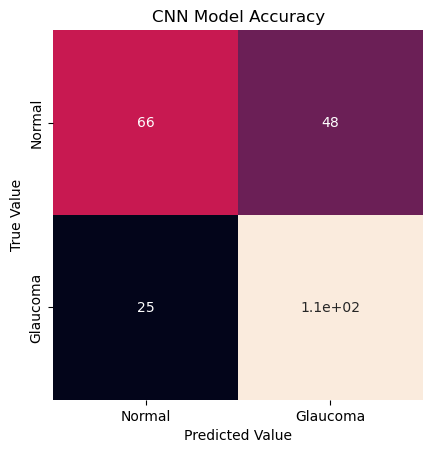

In [23]:
#Confusion Matrix
labels = ['Normal', 'Glaucoma']

cm = confusion_matrix(y_test,y_pred)
accuracy_score(y_test, y_pred)

sns.heatmap(cm, square=True, annot=True, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('CNN Model Accuracy')


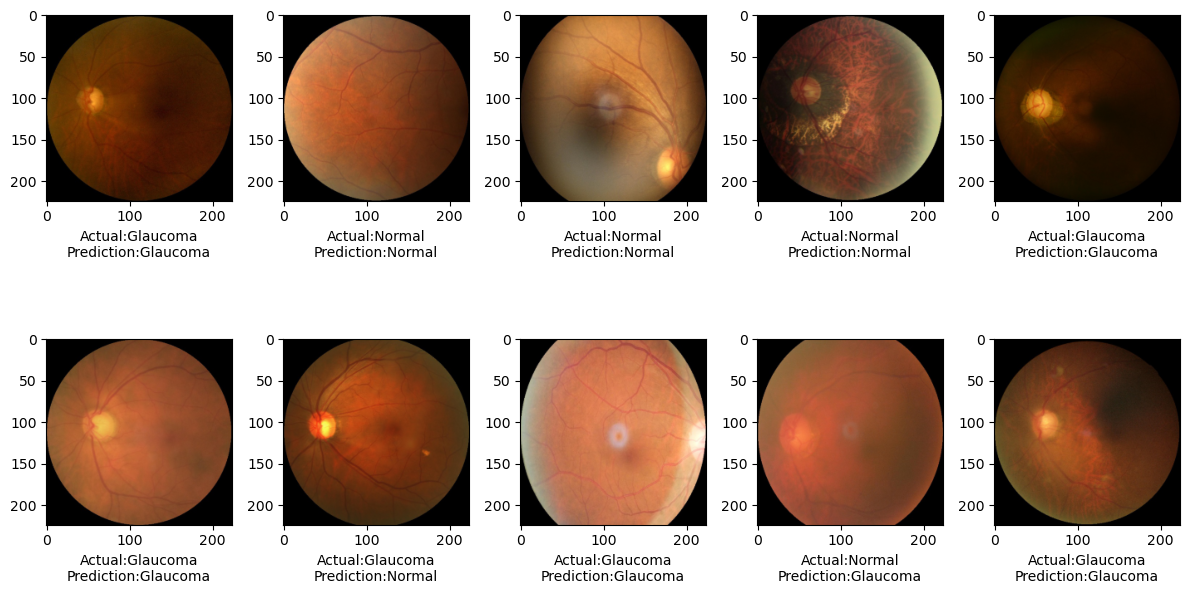

In [18]:
#Testing the algorithm with some samples from the test data to see how it performs
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 